In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from pathlib import Path
import re
import shutil
import string

import tensorflow as tf
from tensorflow.keras.utils import text_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, \
    TextVectorization, Embedding, Dropout, GlobalAveragePooling1D, Activation
from tensorflow.keras.losses import BinaryCrossentropy

# Basic text classification - part 1
Worked example from [here](https://www.tensorflow.org/tutorials/keras/text_classification).

## Download and explore the IMDB dataset

Task: classify IMDB **movie reviews** as positive or negative, based on the text of the review.

Dataset:
- from [here](https://ai.stanford.edu/~amaas/data/sentiment/)
- 25,000 reviews for training and 25,000 reviews for testing
- sets are balanced

acl = Association for Computational Linguistics

In [3]:
def download_data():
    """Downloads the data in the current folder and return the `dataset_dir`."""
    
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')
    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    return dataset_dir

In [4]:
# Data is already download on the Desktop.
dataset_dir = Path().home() / r'Desktop\datasets\aclImdb'
dataset_dir.exists()

True

In [5]:
# Content of the dataset folder.
[obj.name for obj in dataset_dir.glob('*')]

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [6]:
# Define train and test folders and verify they exist.
train_dir = dataset_dir / 'train'
test_dir = dataset_dir / 'test'
train_dir.exists(), test_dir.exists()

(True, True)

In [7]:
# Print out a sample movie review.
sample_file = train_dir / 'neg' / '5_3.txt'
with open(sample_file) as f:
    print(f.read())

I basically skimmed through the movie but just enough to catch watch the plot was about. To tell you the truth it was kind of boring to me and at some spots it didn't make sense. The only reason I watched this movie in the first place was to see CHACE CRAWFORD!!! He is so hot, but in this movie his hair was kind of weird. But still hot.<br /><br />However, despite how hot CHACE is, it really did not make up for the film. I guess the plot isn't that bad but what really threw me over was the fact that they cuss in like every sentence. Is it that hard to express your anger without saying the F word every time?The cussing was annoying and the whole flashy, camera shaking thing gave me a headache.<br /><br />All in all, although the plot was OK, I found the film to be a bore and over dramatic. That's why I only cut to scenes with CHACE in it. LOL Anyways, not worth renting unless your a die-hard fan of a specific cast member like I was. Oh yeah the cast was Hot. The girls were HOT!!! But CH

## Load the dataset

In [8]:
# List the content of the train folder.
[obj.name for obj in train_dir.glob('*')]

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [9]:
# Delete unused folders if needed. Only 'neg' and 'pos' folders shall remain.
def remove_unneccessary_dirs():
    remove_dir = os.path.join(str(train_dir), 'unsup')
    shutil.rmtree(remove_dir)
`
[obj.name for obj in train_dir.glob('*')]

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [10]:
# Create tf dataset for training.
batch_size = 32
seed = 42

raw_train_ds = text_dataset_from_directory(
    directory=train_dir.as_posix(), 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [11]:
# Take a sample batch and print several of the reviews inside and their labels.
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [13]:
# Print out the meanings of the two labels.
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [16]:

raw_val_ds = text_dataset_from_directory(
    directory=train_dir.as_posix(), 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [17]:
raw_test_ds = text_dataset_from_directory(
    directory=test_dir.as_posix(), 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Prepare the dataset for training

In [15]:
# Implement preprocessing function to apply over every movie review.

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [19]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [20]:
# Make a text-only dataset (without labels)
train_text = raw_train_ds.map(lambda x, y: x)

# Fit the vectorize obj with the tesxts
vectorize_layer.adapt(train_text)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [21]:
# need to add a dimension to vectorize
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [22]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))

# take the first observation
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [23]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print(f'Vocabulary size: {len(vectorize_layer.get_vocabulary())}')

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [24]:
# Create the final datasets by
# mapping the TextVectorization layer

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configure the dataset for performance

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

- > The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings).
- Below, we embed a 10,001-word vocabulary (`max_features` + 1) into 16 dimensions.
- The weight are initially random and are gradually adjusted via backpropagation during training.

In [26]:
embedding_dim = 16


model = tf.keras.Sequential([
    Embedding(max_features + 1, embedding_dim),
    Dropout(0.2),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

## Loss function and optimizer

- single column contains the output var -> `from_logits=True`
- Classes are ballanced -> accuracy is good performance metric

In [27]:
model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## Train the model

In [28]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 15s 21ms/step - loss: 0.6621 - binary_accuracy: 0.6999 - val_loss: 0.6121 - val_binary_accuracy: 0.7744
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5458 - binary_accuracy: 0.8029 - val_loss: 0.4959 - val_binary_accuracy: 0.8252
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4427 - binary_accuracy: 0.8461 - val_loss: 0.4183 - val_binary_accuracy: 0.8480
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3763 - binary_accuracy: 0.8665 - val_loss: 0.3724 - val_binary_accuracy: 0.8628
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3338 - binary_accuracy: 0.8792 - val_loss: 0.3441 - val_binary_accuracy: 0.8680
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3036 - binary_accuracy: 0.8903 - val_loss: 0.3253 - val_binary_accuracy: 0.8708
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

In [29]:
# Helper function to get the cosine between two vectors
def get_cos(a, b):
    dot_product = tf.tensordot(a, b, axes=1)
    len_a = tf.norm(a)
    len_b = tf.norm(b)
    cosine = dot_product / (len_a * len_b)
    return cosine

a = tf.constant([0.0, 1.0])
b = tf.constant([2.0, 0.0])
c = tf.constant([4.0, 0.0])
d = tf.constant([1.0, 1.0])

get_cos(a, b).numpy(), get_cos(b, c).numpy(), get_cos(c, d).numpy()

(0.0, 1.0, 0.70710677)

In [30]:
embedding = model.layers[0]

# Two similar words
word_067 = vectorize_layer.get_vocabulary()[67]
word_105 = vectorize_layer.get_vocabulary()[105]
print(word_067, word_105)

# Expecting the words to be similar therefore
# the cos to be close to 1
a = embedding(tf.constant(67))
b = embedding(tf.constant(105))
print(f'Cos({word_067}, {word_105}) = {get_cos(a, b)}')    

# Expecting cos close to 0 for dissimilar words
# take word 5000 at random
word_5000 = vectorize_layer.get_vocabulary()[5000]
c = embedding(tf.constant(5000))
print(f'Cos({word_067}, {word_5000}) = {get_cos(a, c)}')    

see seen
Cos(see, seen) = 0.986045241355896
Cos(see, depicting) = -0.9597927927970886


## Evaluate the model

In [31]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 14s 17ms/step - loss: 0.3100 - binary_accuracy: 0.8736
Loss:  0.31002503633499146
Accuracy:  0.8736400008201599


## Create a plot of accuracy and loss over time

Training vs validation accuracy:
- The training accuracy peaks earlier.
- After several epochs training gets larger than validation meaning the model over-fits the data. Solution: stop when valid acc no longer increases significantly (early stopping). 

In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

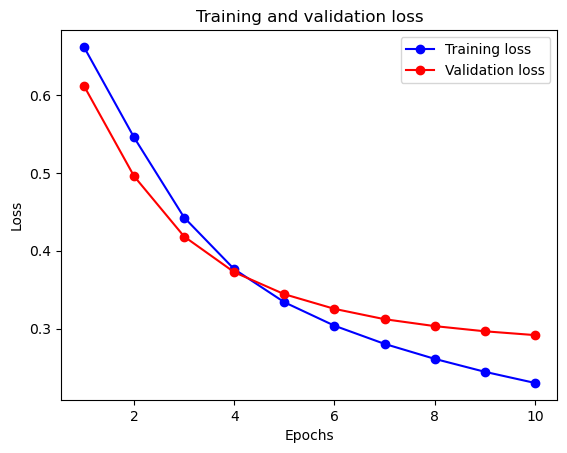

In [33]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b-o', label='Training loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

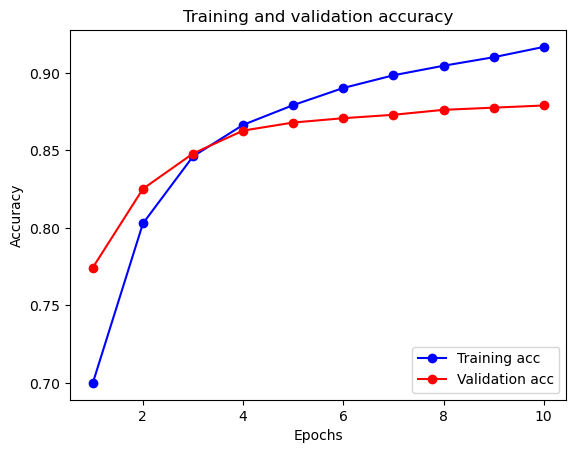

In [34]:
plt.plot(epochs, acc, 'b-o', label='Training acc')
plt.plot(epochs, val_acc, 'r-o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Export the model

- Add the preprocess layer to allow to directly predict raw IMDS reviews.

In [35]:
export_model = Sequential([
  vectorize_layer,
  model,
  Activation('sigmoid')
])

export_model.compile(
    loss=BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 11s 14ms/step - loss: 0.3100 - accuracy: 0.8736
0.8736400008201599


## Inference on new data

In [36]:
examples = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible...",
    "I do not know what to say! I am speechless!",
    "The 'greatest' movie eeeever!",
    "It is really good! Can't wait for the second part! Yey!",
    "Best",
    "Worst"
]

export_model.predict(examples)

1/1 [==============================] - 0s 213ms/step


array([[0.6080666 ],
       [0.4300716 ],
       [0.3476958 ],
       [0.4364942 ],
       [0.5595824 ],
       [0.5416046 ],
       [0.6042695 ],
       [0.29239798]], dtype=float32)